1. Import Necessary Modules


In [19]:
# Import Necessary Modules
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import os
import albumentations as A


2. Data Preparation & Preprocessing


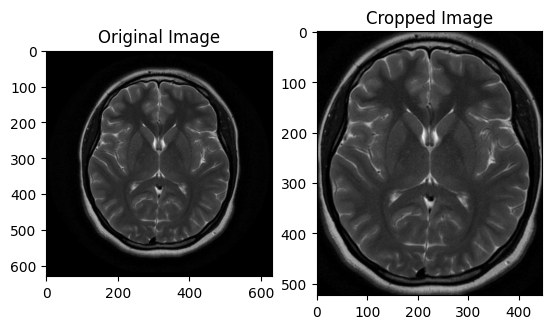

In [17]:
# Function to crop the brain contour from the MRI images
def crop_brain_contour(image, plot=False):
    """
    Crops the brain contour from the MRI image.
    Arguments:
        image: Input image.
        plot: Boolean, if True plots the original and cropped image.
    Returns:
        new_image: Cropped image containing the brain contour.
    """
    if image is None:
        raise ValueError("Image not found or unable to read the image file.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    gray = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to reduce noise

    # Threshold the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)  # Get the largest contour

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop the image using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

# Example usage of the crop_brain_contour function
image_path = 'C:\\Users\\Student\\Desktop\\ML-Project\\TumorTrack\\data\\no\\1 no.jpeg'
if os.path.exists(image_path):
    ex_img = cv2.imread(image_path)
    ex_new_img = crop_brain_contour(ex_img, True)
else:
    print(f"Image not found at path: {image_path}")

Number of examples: 1518
X shape: (1518, 240, 240, 3)
y shape: (1518, 1)


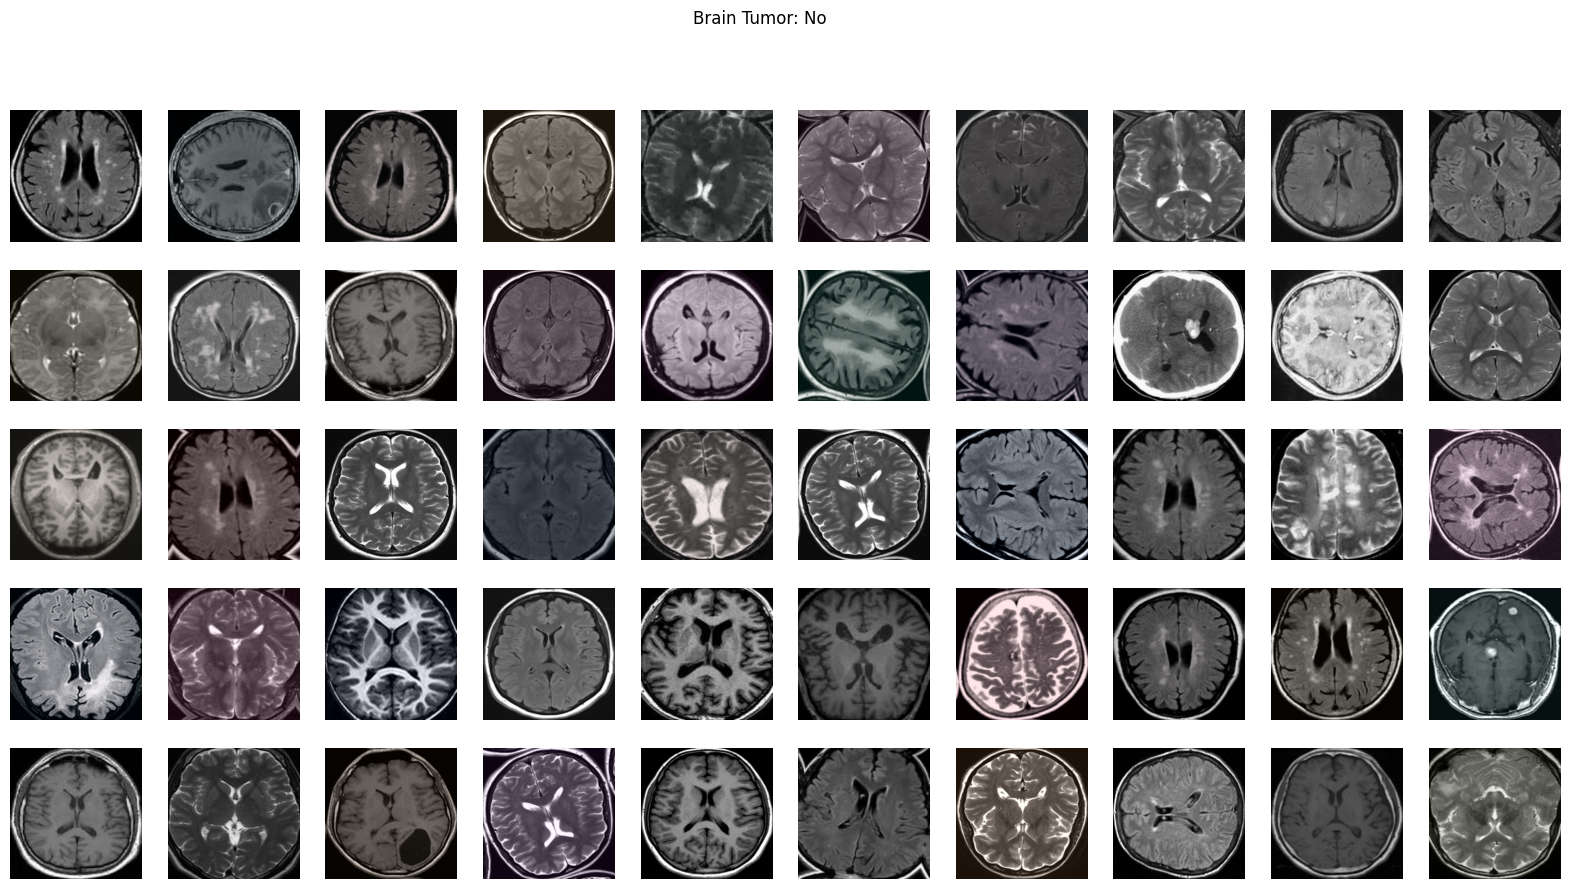

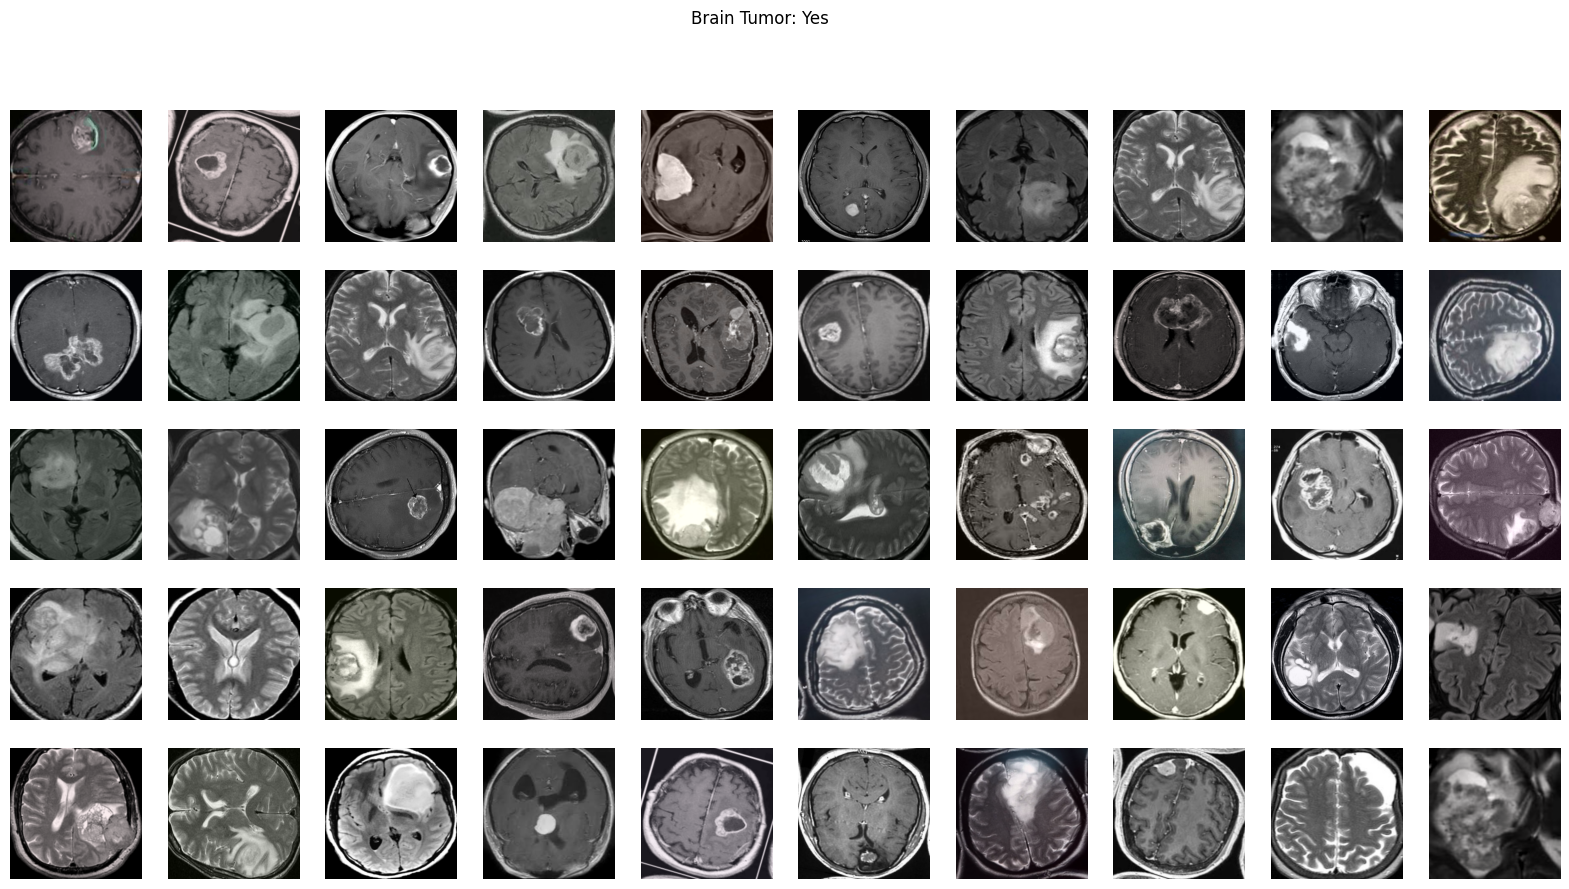

In [38]:
# Define the augmentation pipeline using Albumentations
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=7, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=10, b_shift_limit=10, p=0.5),
    ])

# Function to load, augment and save data
def load_and_augment_data(dir_list, image_size, augmentations, save_dir, augment_times=5):
    """
    Loads, augments, and preprocesses image data.
    Arguments:
        dir_list: List of directories containing the images.
        image_size: Tuple specifying the size to resize images to.
        augmentations: Albumentations augmentation pipeline.
        save_dir: Directory to save augmented images.
        augment_times: Number of times to augment each image.
    Returns:
        X: Array of preprocessed images.
        y: Array of labels corresponding to the images.
    """
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        label = 1 if directory.endswith('yes') else 0
        save_subdir = 'yes' if label == 1 else 'no'
        save_path = os.path.join(save_dir, save_subdir)
        os.makedirs(save_path, exist_ok=True)
        
        for filename in listdir(directory):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Unable to read image at path: {image_path}")
                continue
            
            image = crop_brain_contour(image, plot=False)  # Crop brain contour
            image = cv2.resize(image, (image_width, image_height))  # Resize image
            X.append(image)
            y.append([label])
            
            # Save original image
            save_image_path = os.path.join(save_path, filename)
            cv2.imwrite(save_image_path, image)
            
            # Augment the image multiple times and save
            for i in range(augment_times):
                augmented = augmentations(image=image)['image']
                X.append(augmented)
                y.append([label])
                
                augmented_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                augmented_save_image_path = os.path.join(save_path, augmented_filename)
                cv2.imwrite(augmented_save_image_path, augmented)
    
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)  # Shuffle data
    
    print(f'Number of examples: {len(X)}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    
    return X, y

# Load and augment data
data_path = 'data/'
data_yes = os.path.join(data_path, 'yes')
data_no = os.path.join(data_path, 'no')

save_path = 'augmented_data'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
augmentation_pipeline = get_augmentation_pipeline()

X, y = load_and_augment_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT), augmentation_pipeline, save_path)

# Function to plot sample images
def plot_sample_images(X, y, n=50):
    """
    Plots sample images with their labels.
    Arguments:
        X: Array of images.
        y: Array of labels.
        n: Number of images to plot.
    """
    for label in [0, 1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = n // columns_n

        plt.figure(figsize=(20, 10))
        
        for i, image in enumerate(n_images, 1):
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0], cmap='gray')
            plt.axis('off')
        
        plt.suptitle(f"Brain Tumor: {'Yes' if label == 1 else 'No'}")
        plt.show()

plot_sample_images(X, y)
